In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fp_data = "../results/metrics/"
FNs1 = glob.glob(fp_data+"Metric*AllOnes*adj*.tsv")
FNs2 = glob.glob(fp_data+"Metric*SummedDegree-0.50*2000*0.1_0.001_120_8_10*.tsv")
FNs3 = glob.glob(fp_data+"Metric*AllOnes*2000*0.1_0.001_120_8_10*.tsv")
FNs = FNs1 + FNs2 + FNs3
fp_data2 = "../results/ortholog_metrics/"
FNs1 = glob.glob(fp_data2+"Metric*AllOnes*adj*.tsv")
FNs2 = glob.glob(fp_data2+"Metric*SummedDegree-0.50*2000*0.1_0.001_120_8_10*.tsv")
FNs = FNs + FNs1 + FNs2
df_results = pd.DataFrame()
for aFN in FNs:
    df_tmp = pd.read_csv(aFN,sep="\t")
    if df_tmp.shape[0] == 0:
        # this is for dr BioGRID where there are no terms
        continue
    # remove hs_mm that has AllOnes embeddings
    if ("AllOnes" in aFN) and ("hs_mm" in aFN) and ("Pecanpy" in aFN):
        continue
    GSCtmp = "_".join(df_tmp["GSC_info"].to_list()[0].split("__")[1].split("_")[0:2])
    df_tmp["GSC"] = [GSCtmp] * df_tmp.shape[0]
    df_results = pd.concat([df_results,df_tmp])
df_results.head()

,GSC_info,network,species,connections,feature_type,model_info,ID,name,num_train_pos,num_train_all,num_test_pos,num_test_all,avgp,log2p,auroc,PTopK,GSC
0,MethodNum-0__GO_sc_20_200_0.5_0.5,IMP_raw,sc,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0000041,transition metal ion transport,22,3026,28,1513,0.540938,4.869376,0.834343,15,GO_sc
1,MethodNum-0__GO_sc_20_200_0.5_0.5,IMP_raw,sc,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0000096,sulfur amino acid metabolic process,15,3114,13,1500,0.457960,5.723600,0.887228,6,GO_sc
2,MethodNum-0__GO_sc_20_200_0.5_0.5,IMP_raw,sc,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0000122,negative regulation of transcription by RNA po...,128,2248,17,1402,0.250848,4.370695,0.860183,4,GO_sc
3,MethodNum-0__GO_sc_20_200_0.5_0.5,IMP_raw,sc,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0000959,mitochondrial RNA metabolic process,23,2856,17,1469,0.463471,5.323706,0.894993,7,GO_sc
4,MethodNum-0__GO_sc_20_200_0.5_0.5,IMP_raw,sc,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0001510,RNA methylation,19,3184,16,1586,0.466054,5.529746,0.965844,7,GO_sc


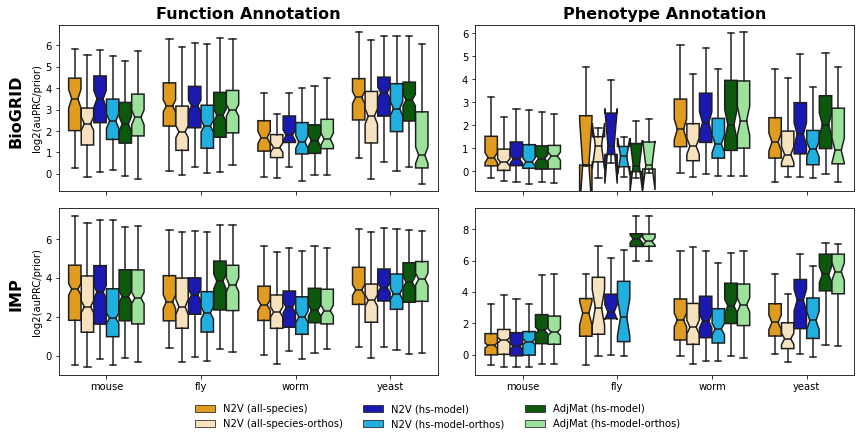

In [3]:
%%capture --no-display
def make_plots2():
    fig, ax = plt.subplots(2,2,figsize=(12,6))
    for idx1, GSC in enumerate(["GO","Monarch"]):
        for idx2, anet in enumerate(["BioGRID_raw","IMP_raw"]):
            if GSC == "GO":
                remove = "Monarch"
            else:
                remove = "GO"

            df_tmp = df_results[(df_results["network"]==anet)&
                                (df_results["GSC"]!="%s_hs"%GSC)&
                                (~df_results["GSC"].str.contains(remove))&
                                (df_results["GSC"]!="DisNet_hs")]
            species_tmp = df_tmp["species"].to_list()
            features_tmp = df_tmp["feature_type"].to_list()
            new_features = []
            for idx, item in enumerate(species_tmp):
                if item == "ce_dm_dr_hs_mm_sc":
                    feature_ = "all-species"
                elif item == "ce_dm_dr_hs_mm_sc_orthos":
                    feature_ = "all-species-orthos"
                elif ("hs" in item) and ("orthos" in item):
                    feature_ = "hs-model-orthos"
                elif "hs" in item:
                    feature_ = "hs-model"
                else:
                    feature_ = "model"
                if features_tmp[idx] == "adj":
                    new_features.append(f"AdjMat ({feature_})")
                else:
                    new_features.append(f"N2V ({feature_})")
            df_tmp["features"] = new_features 
            df_tmp = df_tmp.sort_values(by=["GSC"])
            df_tmp.head()
            myhueorder = ["N2V (all-species)", "N2V (all-species-orthos)",
                          "N2V (hs-model)","N2V (hs-model-orthos)",
                          "AdjMat (hs-model)", "AdjMat (hs-model-orthos)"]
            myorder = [f"{GSC}_mm",f"{GSC}_dm",f"{GSC}_ce",f"{GSC}_sc"]
            sns.boxplot(data=df_tmp,x="GSC",y="log2p",hue="features",
                        notch=True,showfliers=False,hue_order=myhueorder,
                        order=myorder,ax=ax[idx2,idx1],
                        palette=["orange","moccasin",
                                 "mediumblue","deepskyblue",
                                 "darkgreen","lightgreen"])
            if (idx1 == 1) and (idx2 == 1):
                pass
            else:    
                ax[idx2,idx1].get_legend().remove()
            if idx2 == 1:
                ax[idx2,idx1].set_xlabel("")
                ax[idx2,idx1].set_xticklabels(["mouse","fly","worm","yeast"])
            else:
                ax[idx2,idx1].set_xlabel("")
                ax[idx2,idx1].set_xticklabels("")
            if idx1 == 1:
                ax[idx2,idx1].set_ylabel("")
            else:
                ax[idx2,idx1].set_ylabel("log2(auPRC/prior)")
    ax[1,1].legend(ncol=3,loc="center",bbox_to_anchor=(-0.1,-0.25),frameon=False)
    ax[0,0].set_title("Function Annotation",fontsize=16,fontweight="bold")
    ax[0,1].set_title("Phenotype Annotation",fontsize=16,fontweight="bold")
    plt.annotate("BioGRID",xy=(0.01,0.67),xycoords="figure fraction",
                 rotation="vertical",fontsize=16,fontweight="bold")
    plt.annotate("IMP",xy=(0.01,0.30),xycoords="figure fraction",
                 rotation="vertical",fontsize=16,fontweight="bold")
    plt.subplots_adjust(bottom=0.13,hspace=0.1,wspace=0.1,left=0.07,right=0.99,top=0.94)
    fig.savefig('../figures/FigSM6.pdf')
make_plots2()